## Week 9 Medium - 技術分析量化指標與回測

In [1]:
import tejapi 
import pandas as pd
import numpy as np
tejapi.ApiConfig.api_key = "yourkey"
import datetime
import matplotlib.pyplot as plt
from copy import deepcopy

### 1. 資料撈取(TEJAPI)

In [2]:
UMC = tejapi.get(
    'TWN/EWPRCD', 
    coid = '2303',
    mdate={'gte':'2020-04-01', 'lte':'2021-04-25'},
    opts={'columns': ['mdate','open_d','high_d','low_d','close_d', 'volume']}, 
    paginate=True
    )

UMC = UMC.set_index('mdate')

In [3]:
UMC

,open_d,high_d,low_d,close_d,volume
mdate,,,,,
2020-04-01 00:00:00+00:00,13.85,13.85,13.65,13.80,48954.990
2020-04-06 00:00:00+00:00,13.95,14.10,13.80,14.10,75417.890
2020-04-07 00:00:00+00:00,14.25,14.30,13.95,14.15,112835.791
2020-04-08 00:00:00+00:00,14.15,14.30,14.10,14.20,70020.325
2020-04-09 00:00:00+00:00,14.30,14.40,14.10,14.20,40473.210
...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.20,53.70,54.60,146441.798
2021-04-20 00:00:00+00:00,54.20,54.70,53.60,54.10,117157.906
2021-04-21 00:00:00+00:00,53.80,54.50,53.20,53.40,127366.439


### 2. 指標介紹

#### 2-1. MACD

In [4]:
def MACD(DF, a = 12, b =26, c =9):
    '''
    簡單移動平均線: rolling
    指數移動平均線: ewm
    
    MACD: 透過比較兩條長(26)短(12)天數的指數移動平均線(EMA)，相減算出差離值(DIF)後，對差離值再進行一次指數移動平均線的計算。
    '''
    df = DF.copy()
    df["EMA_Fast"] = df['open_d'].ewm(span = a, min_periods = a).mean()
    df["EMA_Slow"] = df['open_d'].ewm(span = b, min_periods = b).mean()
    df["DIF"] = df["EMA_Fast"] - df["EMA_Slow"]
    df["MACD"] = df['DIF'].ewm(span = c, min_periods = c).mean()
    df.dropna(inplace = True)
    
    return df

In [5]:
MACD(UMC)

,open_d,high_d,low_d,close_d,volume,EMA_Fast,EMA_Slow,DIF,MACD
mdate,,,,,,,,,
2020-05-21 00:00:00+00:00,15.00,15.30,14.95,15.3,39817.856,15.324820,15.301682,0.023138,0.083848
2020-05-22 00:00:00+00:00,15.15,15.20,15.05,15.1,33556.829,15.297847,15.289631,0.008215,0.066902
2020-05-25 00:00:00+00:00,15.10,15.10,14.85,15.1,19221.772,15.267334,15.274646,-0.007312,0.050664
2020-05-26 00:00:00+00:00,15.15,15.25,15.10,15.2,23880.256,15.249245,15.264845,-0.015600,0.036433
2020-05-27 00:00:00+00:00,15.25,15.30,15.10,15.1,24006.301,15.249362,15.263683,-0.014321,0.025692
...,...,...,...,...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.20,53.70,54.6,146441.798,52.861718,51.710344,1.151374,0.720042
2021-04-20 00:00:00+00:00,54.20,54.70,53.60,54.1,117157.906,53.067607,51.894763,1.172844,0.810602
2021-04-21 00:00:00+00:00,53.80,54.50,53.20,53.4,127366.439,53.180283,52.035892,1.144391,0.877360


#### 2-2. Bollinger Bands

In [6]:
def BollingerBand(DF, n=20):
    '''
    布林通道：在簡單移動平均線(SMA)上下兩個標準差的地方劃線，形成一個通道。
    '''
    df = DF.copy()
    df['SMA'] = df['close_d'].rolling(window = n).mean()
    df['BB_20dstd_up'] = df['SMA'] + 2*df['close_d'].rolling(window = n).std(ddof=0)
    df['BB_20dstd_down'] = df['SMA'] - 2*df['close_d'].rolling(window = n).std(ddof=0)
    df['BB_width'] = df['BB_20dstd_up'] - df['BB_20dstd_down']
    df.dropna(inplace = True)
    
    return df

In [7]:
BollingerBand(UMC)

,open_d,high_d,low_d,close_d,volume,SMA,BB_20dstd_up,BB_20dstd_down,BB_width
mdate,,,,,,,,,
2020-04-30 00:00:00+00:00,15.45,15.60,15.35,15.55,64768.656,14.9300,16.194674,13.665326,2.529348
2020-05-04 00:00:00+00:00,15.10,15.45,15.05,15.35,47975.074,15.0075,16.171663,13.843337,2.328326
2020-05-05 00:00:00+00:00,15.50,15.55,15.25,15.25,34096.450,15.0650,16.155459,13.974541,2.180917
2020-05-06 00:00:00+00:00,15.25,15.45,15.25,15.30,34763.487,15.1225,16.132191,14.112809,2.019381
2020-05-07 00:00:00+00:00,15.45,15.85,15.30,15.60,85739.112,15.1925,16.128061,14.256939,1.871123
...,...,...,...,...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.20,53.70,54.60,146441.798,51.0275,56.031046,46.023954,10.007092
2021-04-20 00:00:00+00:00,54.20,54.70,53.60,54.10,117157.906,51.4300,56.047402,46.812598,9.234804
2021-04-21 00:00:00+00:00,53.80,54.50,53.20,53.40,127366.439,51.6900,56.132927,47.247073,8.885854


#### 2-3. RSI指標

In [8]:
def RSI(DF, n=14):
    '''
    RSI（相對強弱指標）：用某段時間的股價平均漲幅(只計算上漲時)、平均跌幅(只計算下跌時)來計算，可以看出股價某段時間內的價格強勢或弱勢
    
    n日漲幅平均值 = n日內上漲日總上漲幅度加總 ÷ n
    n日跌幅平均值 = n日內下跌日總下跌幅度加總 ÷ n
    '''
    df = DF.copy()
    df['daliy_change'] = df['close_d'] - df['close_d'].shift(1)
    df['dUp'] = np.where(df['daliy_change'] >= 0, df['daliy_change'], 0)
    df['dDown'] = np.where(df['daliy_change'] < 0, -df['daliy_change'], 0)

    avg_dUp = []
    avg_dDown = []
    dUp = df['dUp'].tolist()
    dDown = df['dDown'].tolist()
    
    for i in range(len(df)):
        if i < n:
            avg_dUp.append(0)
            avg_dDown.append(0)
        elif i == n:
            avg_dUp.append(df['dUp'].ewm(span = n).mean()[n])
            avg_dDown.append(df['dDown'].ewm(span = n).mean()[n])
        else:
            avg_dUp.append(((n-1)*avg_dUp[i-1] + dUp[i])/n)
            avg_dDown.append(((n-1)*avg_dDown[i-1] + dDown[i])/n)
    
    df['avg_dUp'] = np.array(avg_dUp)
    df['avg_dDown'] = np.array(avg_dDown)

    df['RS'] = df['avg_dUp']/df['avg_dDown']
    df['RSI'] = df['RS'].apply(lambda x: x/(1+x) * 100)
    df.dropna(inplace = True)
    
    return df

In [9]:
RSI(UMC)

,open_d,high_d,low_d,close_d,volume,daliy_change,dUp,dDown,avg_dUp,avg_dDown,RS,RSI
mdate,,,,,,,,,,,,
2020-04-23 00:00:00+00:00,15.45,16.0,15.40,15.80,157791.012,0.60,0.60,0.00,0.223103,0.057655,3.869631,79.464564
2020-04-24 00:00:00+00:00,15.90,16.1,15.85,15.90,104062.670,0.10,0.10,0.00,0.214310,0.053537,4.003051,80.012198
2020-04-27 00:00:00+00:00,16.15,16.3,15.90,16.15,121440.284,0.25,0.25,0.00,0.216859,0.049713,4.362260,81.351145
2020-04-28 00:00:00+00:00,15.50,15.6,14.75,15.00,219150.807,-1.15,0.00,1.15,0.201369,0.128304,1.569462,61.081341
2020-04-29 00:00:00+00:00,15.20,15.5,15.20,15.30,96798.319,0.30,0.30,0.00,0.208414,0.119140,1.749322,63.627400
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.2,53.70,54.60,146441.798,0.60,0.60,0.00,0.596451,0.361201,1.651300,62.282650
2021-04-20 00:00:00+00:00,54.20,54.7,53.60,54.10,117157.906,-0.50,0.00,0.50,0.553848,0.371115,1.492387,59.877819
2021-04-21 00:00:00+00:00,53.80,54.5,53.20,53.40,127366.439,-0.70,0.00,0.70,0.514287,0.394607,1.303289,56.583826


#### 2-4. ATR

In [10]:
def ATR(DF, n=14):
    '''
    ATR（真實波動幅度均值）：真實的股價波動區域
    要算出ATR，首先要算出TR，而TR指的是在以下三個數字中最大的那個數字：
        1. 今日最高價減最低價 
        2. 今日最高價減昨日收盤價的絕對值
        3. 今日最低價減昨日收盤價的絕對值
    
    '''
    df = DF.copy()
    df['H-L'] = abs(df['high_d'] - df['low_d'])
    df['H-PC'] = abs(df['high_d'] - df['close_d'].shift())
    df['L-PC'] = abs(df['low_d'] - df['close_d'].shift())
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis =1, skipna =False)
    df['ATR'] = df['TR'].ewm(span =n, min_periods=n).mean()
    df.dropna(inplace = True)
    
    return df

In [11]:
ATR(UMC)

,open_d,high_d,low_d,close_d,volume,H-L,H-PC,L-PC,TR,ATR
mdate,,,,,,,,,,
2020-04-23 00:00:00+00:00,15.45,16.0,15.40,15.80,157791.012,0.60,0.80,0.20,0.8,0.461928
2020-04-24 00:00:00+00:00,15.90,16.1,15.85,15.90,104062.670,0.25,0.30,0.05,0.3,0.437480
2020-04-27 00:00:00+00:00,16.15,16.3,15.90,16.15,121440.284,0.40,0.40,0.00,0.4,0.431919
2020-04-28 00:00:00+00:00,15.50,15.6,14.75,15.00,219150.807,0.85,0.55,1.40,1.4,0.573420
2020-04-29 00:00:00+00:00,15.20,15.5,15.20,15.30,96798.319,0.30,0.50,0.20,0.5,0.562824
...,...,...,...,...,...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.2,53.70,54.60,146441.798,1.50,1.20,0.30,1.5,2.193716
2021-04-20 00:00:00+00:00,54.20,54.7,53.60,54.10,117157.906,1.10,0.10,1.00,1.1,2.047888
2021-04-21 00:00:00+00:00,53.80,54.5,53.20,53.40,127366.439,1.30,0.40,0.90,1.3,1.948169


#### 2-5. KD指標

In [12]:
def KD(DF, n = 14):
    '''
    function to calculate KD
    '''
    df = DF.copy()
    df['High_9D'] = df['high_d'].rolling(n).max()
    df['Low_9D'] = df['low_d'].rolling(n).min()
    df['RSV'] = (df['close_d'] - df['Low_9D']) / (df['High_9D'] - df['Low_9D']) * 100
    df = df.dropna()
    
    df['K'] = np.zeros(len(df))
    df['D'] = np.zeros(len(df))
    
    for i in range(len(df)):
        if i == 0:
            df['K'][i] = 50
            df['D'][i] = 50
        else:
            df['K'][i] = df['K'][i-1]*(2/3) + df['RSV'][i]*(1/3)
            df['D'][i] = df['D'][i-1]*(2/3) + df['K'][i]*(1/3)
    
    return df

In [13]:
KD(UMC)

,open_d,high_d,low_d,close_d,volume,High_9D,Low_9D,RSV,K,D
mdate,,,,,,,,,,
2020-04-22 00:00:00+00:00,14.80,15.2,14.75,15.20,51801.119,15.45,13.65,86.111111,50.000000,50.000000
2020-04-23 00:00:00+00:00,15.45,16.0,15.40,15.80,157791.012,16.00,13.80,90.909091,63.636364,54.545455
2020-04-24 00:00:00+00:00,15.90,16.1,15.85,15.90,104062.670,16.10,13.95,90.697674,72.656801,60.582570
2020-04-27 00:00:00+00:00,16.15,16.3,15.90,16.15,121440.284,16.30,14.10,93.181818,79.498473,66.887871
2020-04-28 00:00:00+00:00,15.50,15.6,14.75,15.00,219150.807,16.30,14.10,40.909091,66.635346,66.803696
...,...,...,...,...,...,...,...,...,...,...
2021-04-19 00:00:00+00:00,54.70,55.2,53.70,54.60,146441.798,57.00,48.80,70.731707,68.585974,71.766216
2021-04-20 00:00:00+00:00,54.20,54.7,53.60,54.10,117157.906,57.00,48.80,64.634146,67.268698,70.267043
2021-04-21 00:00:00+00:00,53.80,54.5,53.20,53.40,127366.439,57.00,49.80,50.000000,61.512466,67.348851


### 3. 回測應用

In [14]:
UMC = deepcopy(UMC)
tickers_signal = {}
tickers_ret = {}

print("Calculating Technical Analysis for ", 'UMC')
UMC["K"] = KD(UMC)["K"]
UMC["DIF"] = MACD(UMC)["DIF"]
UMC["MACD"] = MACD(UMC)["MACD"]
UMC["ATR"] = ATR(UMC)["ATR"]
UMC.dropna(inplace=True)
tickers_signal['UMC'] = ""
tickers_ret['UMC'] = [0]

Calculating Technical Analysis for  UMC


* 買入信號
    - MACD 上升
    - K值 > 70 且 高於前一天K值
* 賣出信號
    - 當日低點 < 前日收盤 - 前日ATR

In [15]:
print("Calculating returns for ","UMC")
ret = []
for i in range(1,len(UMC)):
    buy_signal = UMC["DIF"][i]> UMC["MACD"][i] and \
                 UMC["K"][i]> 70 and \
                 UMC["K"][i] > UMC["K"][i-1]

    sell_signal = UMC["low_d"][i] < UMC["close_d"][i-1] - UMC["ATR"][i-1]

    if tickers_signal["UMC"] == "":
        tickers_ret["UMC"].append(0)
        if buy_signal:
            tickers_signal["UMC"] = "Buy"

    elif tickers_signal["UMC"] == "Buy":
        if sell_signal:
            tickers_signal["UMC"] = ""
            tickers_ret["UMC"].append(((UMC["close_d"][i] - UMC["close_d"][i-1])/UMC["close_d"][i-1]))
        else:
            tickers_ret["UMC"].append((UMC["close_d"][i]/UMC["close_d"][i-1])-1)

UMC['ret'] = np.array(tickers_ret["UMC"])

Calculating returns for  UMC


In [16]:
strategy_df = pd.DataFrame()
strategy_df["UMC"] = UMC['ret']
strategy_df["ret"] = strategy_df.mean(axis=1)

<AxesSubplot:xlabel='mdate'>

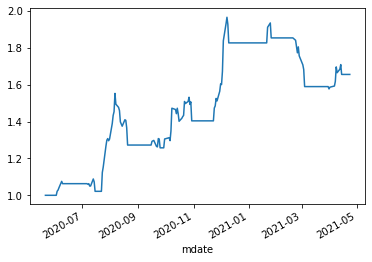

In [17]:
(1+strategy_df["ret"]).cumprod().plot()